# Table of Contens

1. [Import Libraries and Callback functions](#Import)
2. [Download Dataset](#Download-the-Flowers-Dataset)
3. [Explore Dataset](#Print-Information-about-the-Flowers-Dataset)
4. [Reformat Images and Create Batches](#Reformat-Images-and-Create-Batches)
5. [Transfer Learning with MobileNet_v2](#Transfer-Learning-with-MobileNet_v2) 
  
  a. [Create and freeze Feature Extractor](#Create-a-Feature-Extractor) 
  
  b. [Train a model](#Train-a-model) 
  
  c. [Data Augmentation](#Data-Augmentation) 

  d. [Check predictions](#Check-Predictions) 
6. [Transfer Learning with the Inception Model](#Transfer-Learning-with-the-Inception-Model)

# Import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
!pip install tensorflow_hub
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 7.0 MB/s 


In [3]:
import tensorflow_hub as tf_hub

In [4]:
# Callbacks
from tqdm.keras import TqdmCallback
import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.hdf5",
    monitor="val_sparse_categorical_accuracy",
    verbose=1, 
    save_best_only=True,
    mode="max",
    save_freq="epoch"
)

# Download the Flowers Dataset
Since the `tf_flowers` dataset is only split into a TRAINING_SET, we will use `tfds.splits` to split this training set into a `training_set` and `validation_set`. 

Do a [70, 30] split such that 70% data roeewsponds to the `training_set` and 30% to the `validation_set`.

`as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [5]:
tfds_name = "tf_flowers"
(training_set, validation_set), ds_info = tfds.load(
    name=tfds_name,
    split=["train[:70%]", "train[70%:]"],
    as_supervised = True,
    with_info = True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# Print Information about the Flowers Dataset

In [6]:
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print("Name of Classes: {}".format(class_names))
print("Total Number of Classes: {}".format(num_classes))
print("Total Number of Training Images: {}".format(len(training_set)))
print("Total Number of Validation Images: {} \n".format(len(validation_set)))

Name of Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



Visualize first 2 images in the training set.

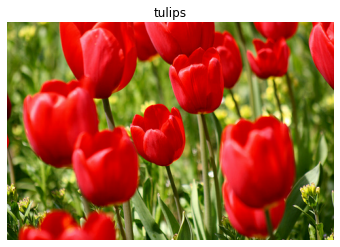

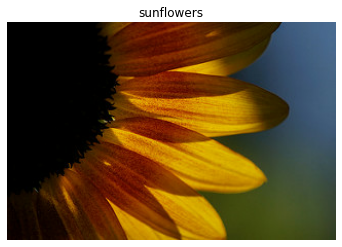

In [7]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(class_names[np.array(label)])
  plt.axis('off')

for image, label in training_set.take(2):
    show(image, label)

# Reformat Images and Create Batches

In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. 

The function should take in an image and a label as arguments and should return the new image and corresponding label. Then create training and validation batches of size 32.

In [8]:
def format_image(image, label):
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])  # Resize
    return image, label

BATCH_SIZE = 32

train_batches = training_set.map(format_image)
train_batches = train_batches.batch(BATCH_SIZE)

validation_batches = validation_set.map(format_image)
validation_batches = validation_batches.batch(BATCH_SIZE)

# Transfer Learning with MobileNet_v2

Let's now use TensorFlow Hub to do Transfer Learning. In transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

## Create a Feature Extractor

In the cell below create a `feature_extractor` using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. 

Go to the TensorFlow Hub documentation to see a list of available feature vectors and then create a `feature_extractor` by using hub.KerasLayer with the correct `input_shape` parameter.

In [9]:
def get_model_MobileNet():
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    MOBILE_NET_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
    mobile_net_keras_layer = hub.KerasLayer(MOBILE_NET_URL, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    # Freeze the Pre-Trained Model
    mobile_net_keras_layer.trainable = False

    # Attach a classification head
    model = tf.keras.Sequential([
        mobile_net_keras_layer,
        tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    return model

## Train the model

Train the model for only 6 epochs.

In [10]:
EPOCHS = 6

model_MobileNet = get_model_MobileNet()
history = model_MobileNet.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[cp_callback, tqdm_callback],
    batch_size=BATCH_SIZE,
    verbose=0
)

Training:   0%|           0/6 ETA: ?s,  ?epochs/s

Epoch 1/6


0/81           ETA: ?s - 


Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.83197, saving model to best_model.hdf5
Epoch 2/6


0/81           ETA: ?s - 


Epoch 00002: val_sparse_categorical_accuracy improved from 0.83197 to 0.86830, saving model to best_model.hdf5
Epoch 3/6


0/81           ETA: ?s - 


Epoch 00003: val_sparse_categorical_accuracy improved from 0.86830 to 0.88193, saving model to best_model.hdf5
Epoch 4/6


0/81           ETA: ?s - 


Epoch 00004: val_sparse_categorical_accuracy improved from 0.88193 to 0.88738, saving model to best_model.hdf5
Epoch 5/6


0/81           ETA: ?s - 


Epoch 00005: val_sparse_categorical_accuracy improved from 0.88738 to 0.88919, saving model to best_model.hdf5
Epoch 6/6


0/81           ETA: ?s - 


Epoch 00006: val_sparse_categorical_accuracy improved from 0.88919 to 0.89282, saving model to best_model.hdf5


## Visualizing results of the training

In the cell below, plot the training and validation accuracy/loss graphs.

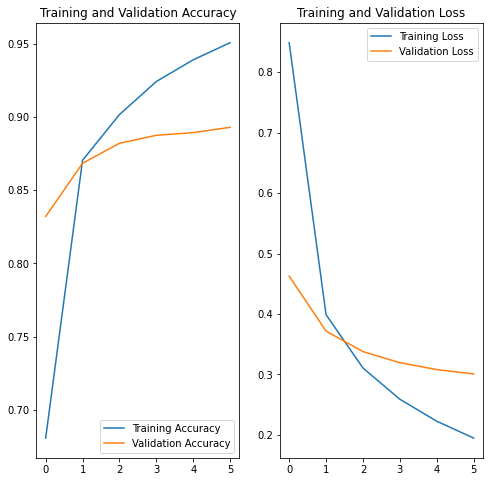

In [11]:
def visualize_model(history, epochs):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

visualize_model(history, EPOCHS)

We get ~88% validation accuracy with only 6 epochs of training, which is absolutely awesome. This is a huge improvement over the model we created from scratch, where we were able to get ~80% accuracy with 100 epochs of training. 

The reason for this difference is that MobileNet v2 was carefully designed over a long time by experts, then trained on a massive dataset.

## Data Augmentation

Data augmentation takes the approach of generating additional training images by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data, prevent overfitting and generalize better.

In the cell below, use Keras to create a transformation that applies a random horizontal/vertical flip, a random 90 degree rotation, a random zoom of up to 150%, and a range for randomly picking a brightness shift value from.

```
# This is formatted as code
```



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def resize_image(image, label):
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])  # Resize
    return image, label

X_train = []
y_train = []
for image, label in training_set.map(resize_image):
    X_train.append(image.numpy())
    y_train.append(label.numpy())


X_test = []
y_test = []
for image, label in validation_set.map(resize_image):
    X_test.append(image.numpy())
    y_test.append(label.numpy())

def get_data_augmentation():
    training_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    train_data_gen = training_data_generator.flow(x=np.array(X_train), 
                                                  y=np.array(y_train), 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=True)
    
    val_data_generator = ImageDataGenerator(rescale=1./255)
    val_data_gen = val_data_generator.flow(x=np.array(X_test), 
                                           y=np.array(y_test))
    
    return train_data_gen, val_data_gen


train_data_gen, val_data_gen = get_data_augmentation()

EPOCHS = 10

model_MobileNet = get_model_MobileNet()
history_1 = model_MobileNet.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[cp_callback, tqdm_callback],
    batch_size=BATCH_SIZE,
    verbose=0
)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/81           ETA: ?s - 


Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.89373
Epoch 2/10


0/81           ETA: ?s - 


Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.89373
Epoch 3/10


0/81           ETA: ?s - 


Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.89373
Epoch 4/10


0/81           ETA: ?s - 


Epoch 00004: val_sparse_categorical_accuracy did not improve from 0.89373
Epoch 5/10


0/81           ETA: ?s - 


Epoch 00005: val_sparse_categorical_accuracy did not improve from 0.89373
Epoch 6/10


0/81           ETA: ?s - 


Epoch 00006: val_sparse_categorical_accuracy did not improve from 0.89373
Epoch 7/10


0/81           ETA: ?s - 


Epoch 00007: val_sparse_categorical_accuracy improved from 0.89373 to 0.89737, saving model to best_model.hdf5
Epoch 8/10


0/81           ETA: ?s - 


Epoch 00008: val_sparse_categorical_accuracy improved from 0.89737 to 0.89918, saving model to best_model.hdf5
Epoch 9/10


0/81           ETA: ?s - 


Epoch 00009: val_sparse_categorical_accuracy did not improve from 0.89918
Epoch 10/10


0/81           ETA: ?s - 


Epoch 00010: val_sparse_categorical_accuracy improved from 0.89918 to 0.90009, saving model to best_model.hdf5


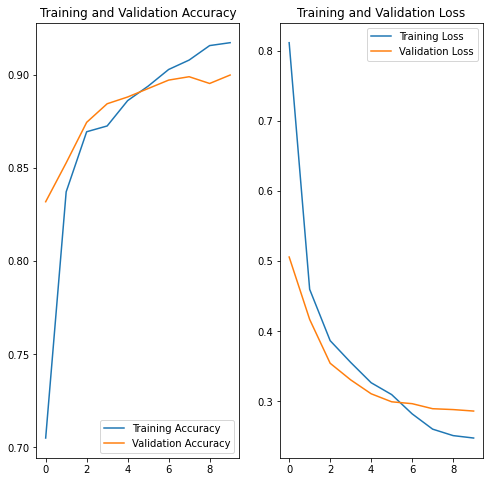

In [14]:
visualize_model(history_1, EPOCHS)

## Check Predictions

#### Create an Image Batch and Make Predictions

In the cell below, use the `next()` function to create an `image_batch` and its corresponding `label_batch`. 

Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. 

Then use the `np.argmax()` function to get the indices of the best prediction for each image. 

Finally convert the indices of the best predictions to class names.

In [18]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

best_model = tf.keras.models.clone_model(model_MobileNet, input_tensors=None, clone_function=None)
best_model.load_weights("best_model.hdf5")

predicted_batch = best_model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = [class_names[id] for id in predicted_ids]

print(predicted_class_names)

['tulips', 'daisy', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'roses', 'daisy', 'tulips', 'daisy', 'daisy', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'roses', 'tulips', 'tulips', 'sunflowers']


#### Print True Labels and Predicted Indices

In the cell below, print the true labels and the indices of predicted labels.

In [19]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 1 2 3 3 3 0 3 2 1 1 1 3 4 2 2 3]
Predicted labels:  [2 1 3 4 3 0 0 0 0 1 3 2 4 1 2 1 1 2 3 3 3 0 3 2 1 1 0 3 4 2 2 3]


#### Plot Model Predictions



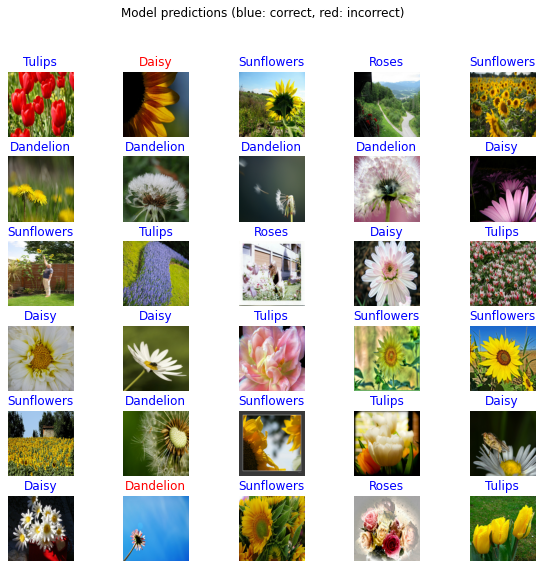

In [20]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# Transfer Learning with the Inception Model

In [21]:
def get_model_Inception():
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    FEATURE_VECTOR_URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
    inception_keras_layer = hub.KerasLayer(FEATURE_VECTOR_URL, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    # Freeze the Pre-Trained Model
    inception_keras_layer.trainable = False

    # Attach a classification head
    model = tf.keras.Sequential([
        inception_keras_layer,
        tf.keras.layers.Dense(units=len(class_names), activation=tf.nn.softmax)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    return model

In [24]:
EPOCHS = 6

model_Inception = get_model_Inception()
history_inception = model_Inception.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[tqdm_callback],
    batch_size=BATCH_SIZE,
    verbose=0
)

Training:   0%|           0/6 ETA: ?s,  ?epochs/s

Epoch 1/6


0/81           ETA: ?s - 

Epoch 2/6


0/81           ETA: ?s - 

Epoch 3/6


0/81           ETA: ?s - 

Epoch 4/6


0/81           ETA: ?s - 

Epoch 5/6


0/81           ETA: ?s - 

Epoch 6/6


0/81           ETA: ?s - 

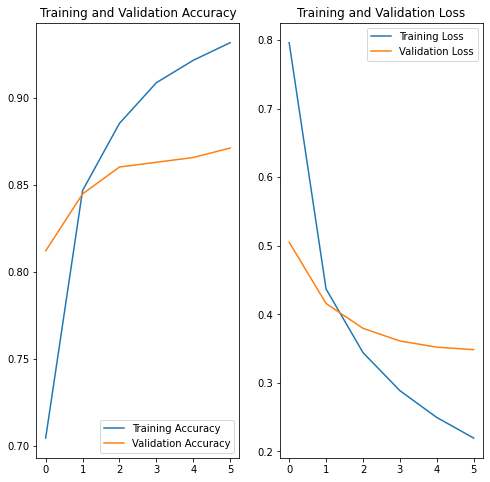

In [25]:
visualize_model(history_inception, EPOCHS)